In [1]:
import bibtexparser
import pandas as pd
from pybtex.database.input import bibtex
import seaborn as sns
from scholarly import scholarly
import csv
import warnings
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from datetime import date


parser = bibtexparser.bparser.BibTexParser(common_strings=True,ignore_nonstandard_types=False)
with open('sample.bib') as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file, parser)


In [9]:
df = pd.DataFrame(bib_database.entries)
df=df.sort_values(by=['year']).rename(columns = {'ENTRYTYPE':'Type of product'})
df = df.astype({'year': int})


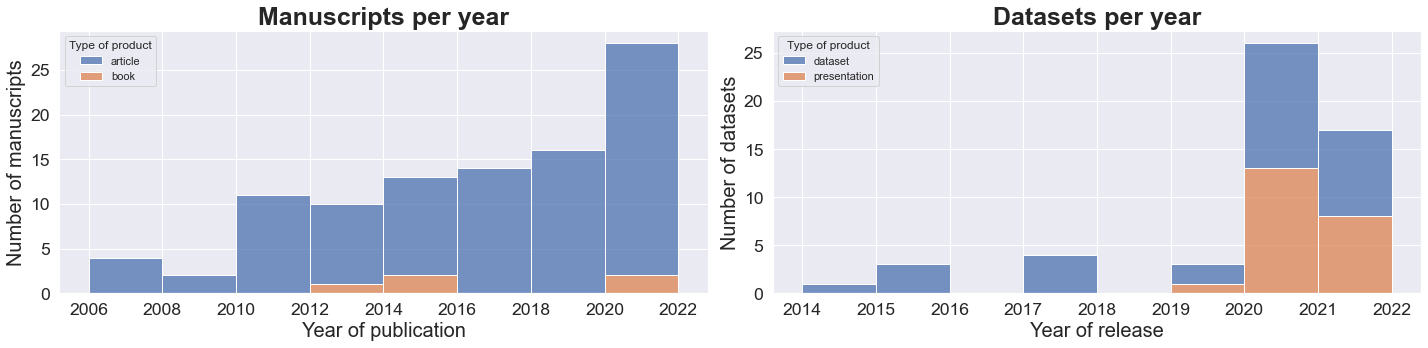

In [3]:
#Split the dataframe into publications and open access data
df_articles_books=df.loc[df['Type of product'] != 'misc']
df_articles_books=df_articles_books.loc[df['Type of product'] != 'dataset']
df_articles_books.reset_index(inplace=True)

df_open_access=df.loc[df['Type of product'] != 'article']
df_open_access=df_open_access.loc[df['Type of product'] != 'book']
df_open_access['Type of product'].replace({'misc':'presentation'},inplace=True)


sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.set_theme(style="darkgrid")
#Plot publications
articles=sns.histplot(df_articles_books,
             x='year',
             hue='Type of product',
             multiple='stack',
             ax=axs[0])
articles.set_xlabel("Year of publication", fontsize = 20)
articles.set_ylabel("Number of manuscripts", fontsize = 20)
#Plot Open access data
OA=sns.histplot(df_open_access,
             x='year',
             hue='Type of product',
             bins=8,
             multiple='stack',
             ax=axs[1])
OA.set_xlabel("Year of release", fontsize = 20)
OA.set_ylabel("Number of datasets", fontsize = 20)

axs[0].set_title('Manuscripts per year',fontdict={'fontsize': 25},fontweight="bold")
axs[1].set_title('Datasets per year',fontdict={'fontsize': 25},fontweight="bold")
plt.tight_layout()
plt.savefig('img/products_per_year.png',format='png', transparent=True)

In [14]:
df_articles_books['Type of product'].value_counts()

article    93
book        4
Name: Type of product, dtype: int64

In [4]:
# The following is modified from: https://github.com/ubcbraincircuits/scholar_metrics_scraper
author_names=['Alessio Rovere']
affiliations = ['MARUM, University of Bremen & Leibniz Centre for Tropical Marine Research']
First_Publication_year=2010

In [5]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for athr in author_names:
    pubs = []
    try :
        if ' ' in athr:
            search_query = scholarly.search_author(athr)
            author = next(search_query) 
        else:
            author = scholarly.search_author_id(athr)
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': athr, 'Warning': 'no information found'}
    else:
        data_dict = scholarly.fill(author, sections=['basics', 'indices', 'publications', 'counts'])
        
        # Get publications titles 
        for pub in data_dict['publications']:
            pubs.append(pub['bib']['title'])
            # Add to dictionary with title as key and author as value
            pub_authors.setdefault(pub['bib']['title'],[]).append(data_dict['name'])
        
        # Get citations per year and put in dictionary
        cites_per_year_dict = data_dict['cites_per_year']
        # Add name to dictionary 
        cites_per_year_dict['name'] = data_dict['name']
        cites_per_year.append(cites_per_year_dict)
        
        # Create row (dictionary) for output data table
        row = {'Name': data_dict['name'], 'Scholar ID': data_dict['scholar_id'], 
               'Cited by': data_dict.get('citedby', ''), 'Cited by 5 years': data_dict.get('citedby5y',''), 
               'h-index': data_dict.get('hindex',''), 'h-index 5 years': data_dict.get('hindex5y',''), 
               'i10-index': data_dict.get('i10index',''),'i10-index 5 years': data_dict.get('i10index5y',''), 
               'Publications': pubs, 'Document Count': len(pubs), 'Affiliation': data_dict['affiliation']}
        
        # Create list of authors who do not have the specified affiliation
        if not any(a in data_dict['affiliation'] for a in affiliations):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)   

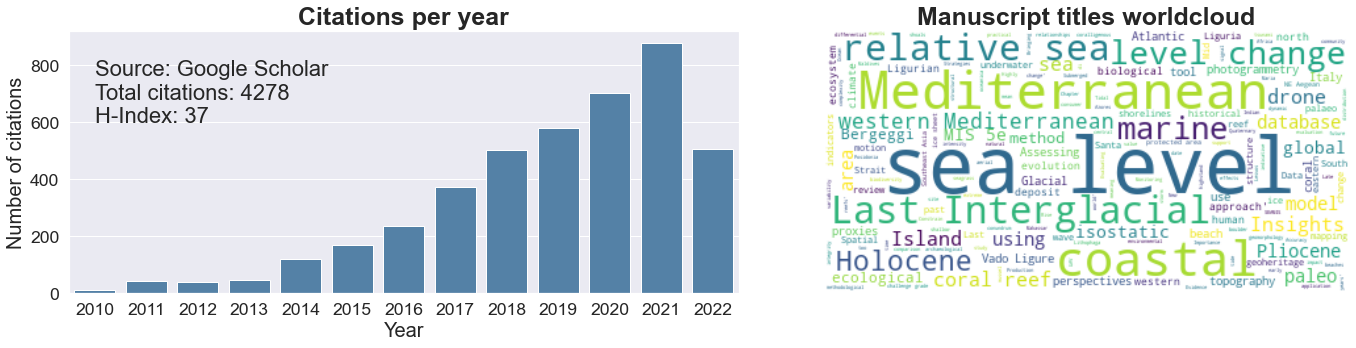

In [74]:
current_year = date.today().year
years_list=num_list = list(range(First_Publication_year,current_year+1))

# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[years_list]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]

sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.set_theme(style="darkgrid")
#Plot citations per year
citations=sns.barplot(x=years,y=cites,color='steelblue',ax=axs[0])
citations.set_xlabel("Year", fontsize = 20)
citations.set_ylabel("Number of citations", fontsize = 20)

text=str('Source: Google Scholar \nTotal citations: '+str(data_dict.get('citedby')) + '\nH-Index: '+str(data_dict.get('hindex')))
axs[0].text(0, 600, text,fontsize=22);


from wordcloud import WordCloud,STOPWORDS
text = df_articles_books['title'].values 

stopwords = set(STOPWORDS)
stopwords.add("NW")


wordcloud = WordCloud(background_color="white", max_words=2000,
            contour_width=3, contour_color='steelblue',stopwords=stopwords).generate(str(text))

axs[1].imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

axs[0].set_title('Citations per year',fontdict={'fontsize': 25},fontweight="bold")
axs[1].set_title('Manuscript titles worldcloud',fontdict={'fontsize': 25},fontweight="bold")



plt.tight_layout()
plt.savefig('img/citations_wordcloud.png',format='png', transparent=True)

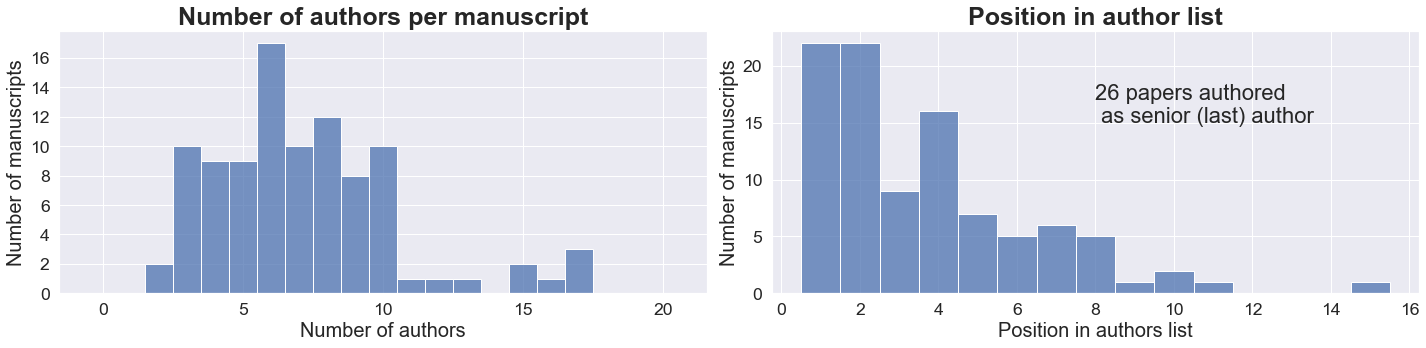

In [6]:
author_stats = pd.DataFrame(columns=['authors', 'num', 'pos'])
df_articles_books=df_articles_books.dropna(subset=['author'])

for k in range(len(df_articles_books)):
 aut_list=str(df_articles_books.author[k])
 #Removing bold and underlined names
 aut_list=aut_list.replace('{\\underline{','').replace('{\\textbf{','').replace('}}','')
 aut_list = list(aut_list.split('and '))

 #Clean first names
 for i in range(len(aut_list)):
  aut_list[i]=aut_list[i].split(',')[0]

 #Count number of authors and position of target author in the list.
 num=len(aut_list)
 pos=aut_list.index('Rovere')+1

 authors=','.join(aut_list)

 d = {'authors': [authors],
        'num': [num],
       'pos':[pos]}
   
 # Create DataFrame
 df = pd.DataFrame(data=d)
 author_stats=author_stats.append(df)
    
sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.set_theme(style="darkgrid")
#Plot nb of authors per paper (truncating papers with more than 20 authors)
nb_authors=sns.histplot(author_stats,
             x='num',
             binrange=[0,20],discrete=True,ax=axs[0])
nb_authors.set_xlabel("Number of authors", fontsize = 20)
nb_authors.set_ylabel("Number of manuscripts", fontsize = 20)

#Plot position in authors list
position=sns.histplot(author_stats,
             x='pos',discrete=True,ax=axs[1])
position.set_xlabel("Position in authors list", fontsize = 20)
position.set_ylabel("Number of manuscripts", fontsize = 20)

#Count papers authored as last (senior) author
author_stats['lastauthor']=author_stats['pos']/author_stats['num']
last_author=author_stats['lastauthor'].value_counts()[1]


text=str(str(last_author) + ' papers authored\n as senior (last) author')
axs[1].text(8, 15, text,fontsize=22);

axs[0].set_title('Number of authors per manuscript',fontdict={'fontsize': 25},fontweight="bold")
axs[1].set_title('Position in author list',fontdict={'fontsize': 25},fontweight="bold")
plt.tight_layout()



plt.savefig('img/authors.png',format='png', transparent=True)

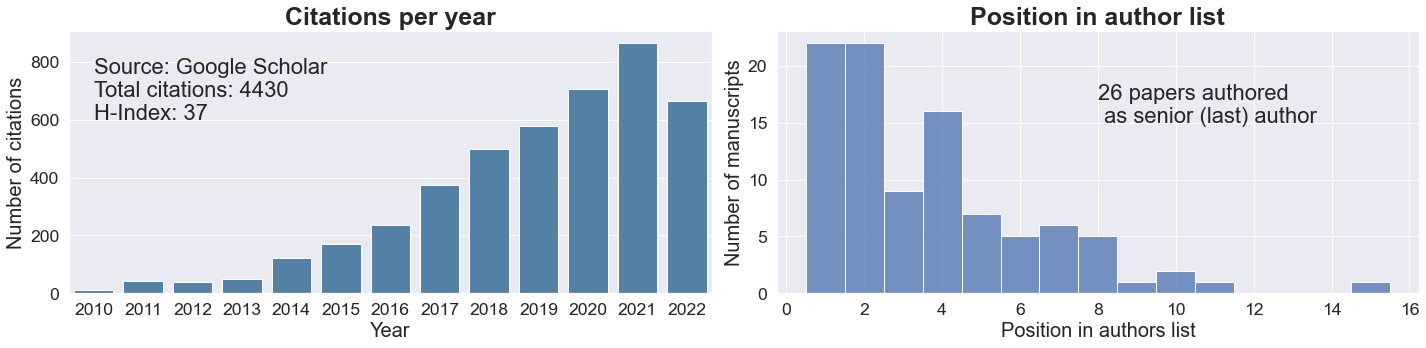

In [7]:
current_year = date.today().year
years_list=num_list = list(range(First_Publication_year,current_year+1))

# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[years_list]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]

sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.set_theme(style="darkgrid")
#Plot citations per year
citations=sns.barplot(x=years,y=cites,color='steelblue',ax=axs[0])
citations.set_xlabel("Year", fontsize = 20)
citations.set_ylabel("Number of citations", fontsize = 20)

text=str('Source: Google Scholar \nTotal citations: '+str(data_dict.get('citedby')) + '\nH-Index: '+str(data_dict.get('hindex')))
axs[0].text(0, 600, text,fontsize=22);
axs[0].set_title('Citations per year',fontdict={'fontsize': 25},fontweight="bold")

#Plot position in authors list
position=sns.histplot(author_stats,
             x='pos',discrete=True,ax=axs[1])
position.set_xlabel("Position in authors list", fontsize = 20)
position.set_ylabel("Number of manuscripts", fontsize = 20)

#Count papers authored as last (senior) author
author_stats['lastauthor']=author_stats['pos']/author_stats['num']
last_author=author_stats['lastauthor'].value_counts()[1]


text=str(str(last_author) + ' papers authored\n as senior (last) author')
axs[1].text(8, 15, text,fontsize=22);

axs[1].set_title('Position in author list',fontdict={'fontsize': 25},fontweight="bold")




plt.tight_layout()
plt.savefig('img/citations_authors.png',format='png', transparent=True)